In [4]:
# Research Project - Remnant bulge profile                                                                                                         
# Rotation Curves   
# William Lake

# import modules                                                                                                       
import numpy as np
import astropy.units as u
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
import math
from matplotlib.pyplot import *
%matplotlib inline
from astropy.constants import G
G = G.to(u.kpc * u.km ** 2 / u.s ** 2 / u.Msun) # Converts the gravitational constant to our desired units

In [57]:
class MassProfile2:
    
    def __init__(self, galaxy, galaxy2, snap):
        # This function/class takes the galaxy name and snapshot number as inputs
        
        # The following three lines create the part of the filename that describe the Snap number, and then generate the filename
        ilbl = '000' + str(snap)
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        time, total, data = Read(self.filename) # Read the data
        self.filename2 = "%s_"%(galaxy2) + ilbl + '.txt'
        time2, total2, data2 = Read(self.filename2) # Read the data
        x = np.array(data['x'])
        x = np.append(x, np.array(data2['x']))
        self.x = x * u.kpc # Import the x, y, and z coordinates with correct units
        y = np.array(data['y'])
        y = np.append(y, np.array(data2['y']))
        self.y = y * u.kpc
        z = np.array(data['z'])
        z = np.append(z, np.array(data2['z']))
        self.z = z * u.kpc
        m = np.array(data['m'])
        self.m1 = np.sum(m)
        self.m2 = np.sum(data2['m'])
        m = np.append(m, np.array(data2['m']))
        self.m = m # Import the mass data
        self.data = np.append(data, data2) # Wasn't asked for but useful later
        self.gname = galaxy # Stores galaxy name
        self.gname2 = galaxy2
        
    def distance(self, x1, x2, y1, y2, z1, z2):
        # This function describes the absolute distance between points (x1,y1,z1) and (x2, y2, z2)
        return np.sqrt(((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2))
    
    def MassEnclosed(self, pType, rArray):
        # Takes as input the particle type and an array of radii
        # Returns the enclosed mass of that type of particle in the galaxy from each radius
        
        # First, we determine the COM position, as we did last week:
        COM_Object = CenterOfMass(self.filename, 2)
        X_COM, Y_COM, Z_COM = COM_Object.COM_P(1.0) * u.kpc # Finds the center of mass coordinates of the first galaxy
        
        COM_Object2 = CenterOfMass(self.filename2, 2)
        X_COM2, Y_COM2, Z_COM2 = COM_Object2.COM_P(1.0) * u.kpc
        
        X_COM = (X_COM * self.m1 + X_COM2 * self.m2) / (self.m1 + self.m2) # Finds the center of mass coordinates for the remnant
        Y_COM = (Y_COM * self.m1 + Y_COM2 * self.m2) / (self.m1 + self.m2)
        Z_COM = (Z_COM * self.m1 + Z_COM2 * self.m2) / (self.m1 + self.m2)
        
        typeIndex = np.where(self.data['type'] == 3)
        
        Radii = self.distance(self.x[typeIndex], X_COM, self.y[typeIndex], Y_COM, self.z[typeIndex], Z_COM) 
        # Creates an array to hold distances of particles from the COM
        self.m = self.m[typeIndex]
        
        masses = np.zeros(len(rArray)) # Creates our result array
        
        for index in range(len(rArray)):
            # Loops over rArray to find enclosed mass
            indices = np.where(Radii < rArray[index])
            masses[index] = sum(self.m[indices])
            
        return masses * u.Msun * 10 ** 10
    
    def MassEnclosedTotal(self, rArray):
        # Takes as input an array of radii
        # Returns the enclosed mass in the galaxy from each radius
        masses = np.zeros(len(rArray)) # Creates our result array
        for i in range(3):
            if(self.gname != 'M33' or i < 2):
                masses += self.MassEnclosed(i+1, rArray) # This adds the contributions of a given particle type to the total mass
                
        return masses * u.Msun

    def HernquistMass(self, radius, a, mHalo):
        # This function takes as input the radius, scale factor a, and Halo mass, and returns the enclosed mass in units M_sun
        return mHalo * (radius ** 2) / (a + radius) ** 2
    
    def CircularVelocity(self, pType, rArray):
        # Takes as input the particle type and an array of radii
        # Returns the velocity of a particle in circular orbit at each radius, due to the mass enclosed of type pType
        # The formula for this is based on a force balance, GM/r^2 = v^2 / r, v=Sqrt(GM/r)
        mass = self.MassEnclosed(pType, rArray)
        return np.around(np.sqrt(G * np.divide(mass, rArray)), decimals=2)
    
    def CircularVelocityTotal(self, rArray):
        # Takes as input an array of radii
        # Returns the velocity of a particle in circular orbit at each radius, due to the mass enclosed
        # The formula for this is based on a force balance, GM/r^2 = v^2 / r, v=Sqrt(GM/r)
        mass = self.MassEnclosedTotal(rArray)
        return np.around(np.sqrt(G * np.divide(mass, rArray)), decimals=2)
    
    def HernquistVCirc(self, radius, a, mHalo):
        # This function takes as input the radius, scale factor a, and Halo mass, and returns the Hernquist circular velocity
        mass = self.HernquistMass(radius, a, mHalo)
        return np.around(np.sqrt(G * np.divide(mass, radius)), decimals=2)

25744666079.998714 solMass


Text(0.5,1,'Radius vs Enclosed Mass, Merger Remnant')

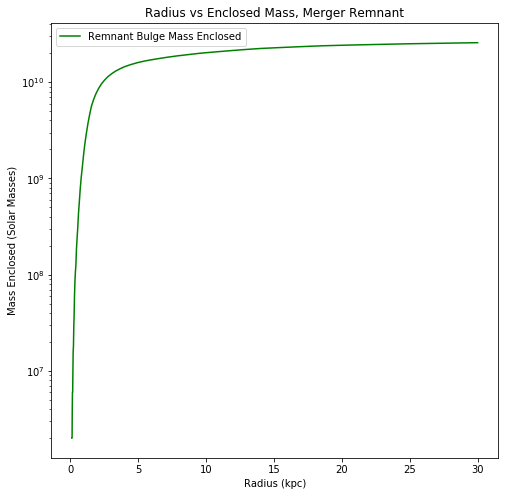

In [58]:
mp = MassProfile2('MW', 'M31', 800)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

Bulge = mp.MassEnclosed(3,radiusArray) # Array describing enclosed bulge type masses in the remnant

print(Bulge[0])

fig = figure(figsize=(8,8))
semilogy(radiusArray, Bulge,'g', label = 'Remnant Bulge Mass Enclosed')


legend()
xlabel('Radius (kpc)')
ylabel('Mass Enclosed (Solar Masses)')
title('Radius vs Enclosed Mass, Merger Remnant')

